In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### **Data loading**

In [15]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Innomatics internship/diminos_data.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())
print("\nDataset Info:")
df.info()


Dataset Shape: (15000, 3)

First 5 rows:


,order_id,order_placed_at,order_delivered_at
0,1523111,2023-03-01 00:00:59,2023-03-01 00:18:07.443132
1,1523112,2023-03-01 00:03:59,2023-03-01 00:19:34.925241
2,1523113,2023-03-01 00:07:22,2023-03-01 00:22:28.291385
3,1523114,2023-03-01 00:07:47,2023-03-01 00:46:19.019399
4,1523115,2023-03-01 00:09:03,2023-03-01 00:25:13.619056



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_id            15000 non-null  int64 
 1   order_placed_at     15000 non-null  object
 2   order_delivered_at  15000 non-null  object
dtypes: int64(1), object(2)
memory usage: 351.7+ KB


In [16]:
df.columns = df.columns.str.strip()
df.columns

Index(['order_id', 'order_placed_at', 'order_delivered_at'], dtype='object')

### **Data cleaning and preparation**

In [17]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Convert timestamp columns to datetime
df['order_placed_at'] = pd.to_datetime(df['order_placed_at'])
df['order_delivered_at'] = pd.to_datetime(df['order_delivered_at'])

# Calculate delivery duration in minutes
df['delivery_duration_minutes'] = (df['order_delivered_at'] - df['order_placed_at']).dt.total_seconds() / 60

# Check for any negative or unrealistic delivery times
print(f"\nOrders with negative delivery time: {(df['delivery_duration_minutes'] < 0).sum()}")
print(f"Orders with delivery time > 120 minutes (potential outliers): {(df['delivery_duration_minutes'] > 120).sum()}")

# Remove unrealistic values (if any)
df = df[(df['delivery_duration_minutes'] >= 0) & (df['delivery_duration_minutes'] <= 120)]

# Extract time-based features
df['order_hour'] = df['order_placed_at'].dt.hour
df['order_day'] = df['order_placed_at'].dt.day_name()
df['order_month'] = df['order_placed_at'].dt.month_name()
df['is_weekend'] = df['order_placed_at'].dt.dayofweek >= 5
df['order_date'] = df['order_placed_at'].dt.date

# Time of day categorization
def categorize_time(hour):
    if 5 <= hour < 11:
        return 'Early Morning (5-10)'
    elif 11 <= hour < 16:
        return 'Lunch (11-15)'
    elif 16 <= hour < 20:
        return 'Evening (16-19)'
    elif 20 <= hour < 24:
        return 'Night (20-23)'
    else:
        return 'Late Night (0-4)'

df['time_category'] = df['order_hour'].apply(categorize_time)

Missing Values:
order_id              0
order_placed_at       0
order_delivered_at    0
dtype: int64

Orders with negative delivery time: 0
Orders with delivery time > 120 minutes (potential outliers): 69


In [18]:
df.shape

(14931, 10)

In [19]:
df.head()

,order_id,order_placed_at,order_delivered_at,delivery_duration_minutes,order_hour,order_day,order_month,is_weekend,order_date,time_category
0,1523111,2023-03-01 00:00:59,2023-03-01 00:18:07.443132,17.140719,0,Wednesday,March,False,2023-03-01,Late Night (0-4)
1,1523112,2023-03-01 00:03:59,2023-03-01 00:19:34.925241,15.598754,0,Wednesday,March,False,2023-03-01,Late Night (0-4)
2,1523113,2023-03-01 00:07:22,2023-03-01 00:22:28.291385,15.104856,0,Wednesday,March,False,2023-03-01,Late Night (0-4)
3,1523114,2023-03-01 00:07:47,2023-03-01 00:46:19.019399,38.533657,0,Wednesday,March,False,2023-03-01,Late Night (0-4)
4,1523115,2023-03-01 00:09:03,2023-03-01 00:25:13.619056,16.176984,0,Wednesday,March,False,2023-03-01,Late Night (0-4)


In [20]:
df['order_month'].value_counts()

,count
order_month,
March,14931


### **Key metric calaculation -95th percentile**

In [21]:
# Calculate overall 95th percentile
overall_p95 = np.percentile(df['delivery_duration_minutes'], 95)
print(f"Overall 95th Percentile Delivery Time: {overall_p95:.2f} minutes")
print(f"Target (31 minutes): {'MET' if overall_p95 <= 31 else 'NOT MET'}")

# Calculate percentage of orders exceeding 31 minutes
orders_exceeding_31 = (df['delivery_duration_minutes'] > 31).sum()
total_orders = len(df)
print(f"\nOrders exceeding 31 minutes: {orders_exceeding_31}/{total_orders} ({orders_exceeding_31/total_orders*100:.2f}%)")

# Financial impact (assuming average order value)
avg_order_value = 500  # Assuming average order value in INR
financial_risk = orders_exceeding_31 * avg_order_value
print(f"Estimated monthly financial risk (free pizzas): ₹{financial_risk:,.0f}")

Overall 95th Percentile Delivery Time: 26.25 minutes
Target (31 minutes): MET

Orders exceeding 31 minutes: 488/14931 (3.27%)
Estimated monthly financial risk (free pizzas): ₹244,000


### **Visualization and analysis**

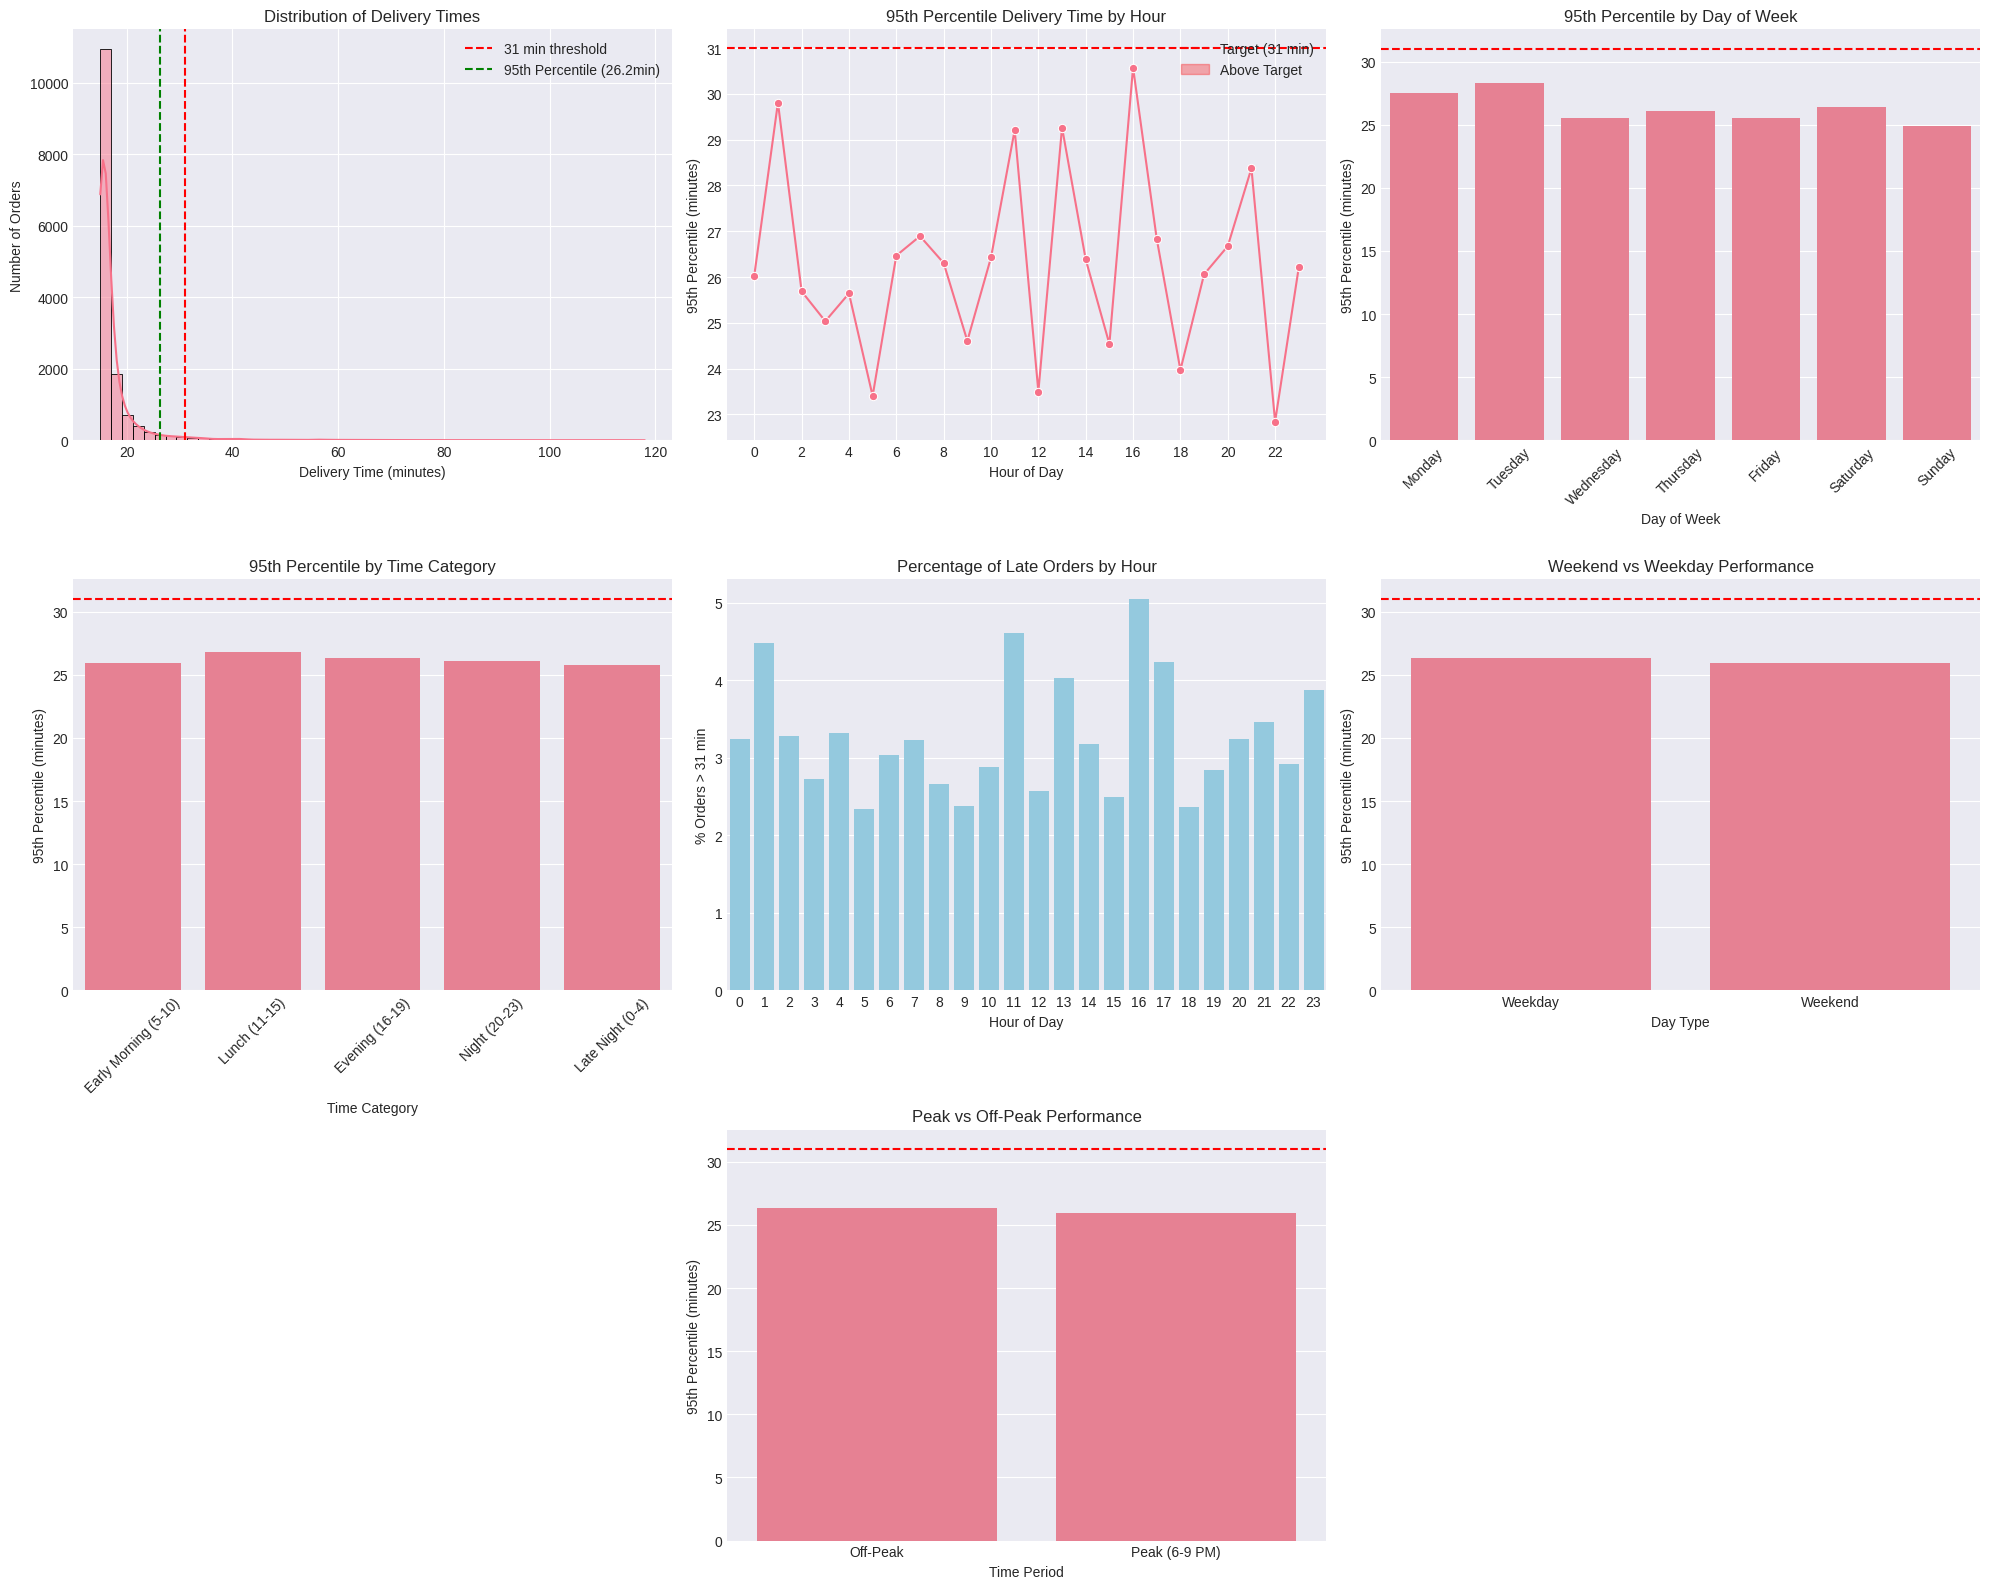

In [22]:
# Set up the visualization grid
fig = plt.figure(figsize=(20, 16))

# 1. Distribution of delivery times
ax1 = plt.subplot(3, 3, 1)
sns.histplot(data=df, x='delivery_duration_minutes', bins=50, kde=True)
plt.axvline(x=31, color='red', linestyle='--', label='31 min threshold')
plt.axvline(x=overall_p95, color='green', linestyle='--', label=f'95th Percentile ({overall_p95:.1f}min)')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Number of Orders')
plt.title('Distribution of Delivery Times')
plt.legend()

# 2. 95th Percentile by hour of day
ax2 = plt.subplot(3, 3, 2)
hourly_p95 = df.groupby('order_hour')['delivery_duration_minutes'].agg(lambda x: np.percentile(x, 95)).reset_index()
sns.lineplot(data=hourly_p95, x='order_hour', y='delivery_duration_minutes', marker='o')
plt.axhline(y=31, color='red', linestyle='--', label='Target (31 min)')
plt.fill_between(hourly_p95['order_hour'], 31, hourly_p95['delivery_duration_minutes'],
                 where=hourly_p95['delivery_duration_minutes']>31, color='red', alpha=0.3, label='Above Target')
plt.xlabel('Hour of Day')
plt.ylabel('95th Percentile (minutes)')
plt.title('95th Percentile Delivery Time by Hour')
plt.xticks(range(0, 24, 2))
plt.legend()

# 3. 95th Percentile by day of week
ax3 = plt.subplot(3, 3, 3)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_p95 = df.groupby('order_day')['delivery_duration_minutes'].agg(lambda x: np.percentile(x, 95)).reindex(day_order).reset_index()
sns.barplot(data=daily_p95, x='order_day', y='delivery_duration_minutes')
plt.axhline(y=31, color='red', linestyle='--', label='Target')
plt.xlabel('Day of Week')
plt.ylabel('95th Percentile (minutes)')
plt.title('95th Percentile by Day of Week')
plt.xticks(rotation=45)

# 4. Time category analysis
ax4 = plt.subplot(3, 3, 4)
time_cat_order = ['Early Morning (5-10)', 'Lunch (11-15)', 'Evening (16-19)', 'Night (20-23)', 'Late Night (0-4)']
time_cat_p95 = df.groupby('time_category')['delivery_duration_minutes'].agg(lambda x: np.percentile(x, 95)).reindex(time_cat_order).reset_index()
sns.barplot(data=time_cat_p95, x='time_category', y='delivery_duration_minutes')
plt.axhline(y=31, color='red', linestyle='--')
plt.xlabel('Time Category')
plt.ylabel('95th Percentile (minutes)')
plt.title('95th Percentile by Time Category')
plt.xticks(rotation=45)

# 5. Orders exceeding 31 minutes by hour
ax5 = plt.subplot(3, 3, 5)
hourly_exceed = df.groupby('order_hour')['delivery_duration_minutes'].apply(lambda x: (x > 31).mean() * 100).reset_index()
sns.barplot(data=hourly_exceed, x='order_hour', y='delivery_duration_minutes', color='skyblue')
plt.xlabel('Hour of Day')
plt.ylabel('% Orders > 31 min')
plt.title('Percentage of Late Orders by Hour')
plt.xticks(rotation=0)

# 6. Weekend vs Weekday
ax7 = plt.subplot(3, 3, 6)
weekend_p95 = df.groupby('is_weekend')['delivery_duration_minutes'].agg(lambda x: np.percentile(x, 95)).reset_index()
weekend_p95['is_weekend'] = weekend_p95['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
sns.barplot(data=weekend_p95, x='is_weekend', y='delivery_duration_minutes')
plt.axhline(y=31, color='red', linestyle='--')
plt.xlabel('Day Type')
plt.ylabel('95th Percentile (minutes)')
plt.title('Weekend vs Weekday Performance')

# 7. Peak vs Off-Peak hours (custom definition)

df['is_peak'] = df['order_hour'].between(18, 21)  # 6 PM to 9 PM as peak
peak_p95 = df.groupby('is_peak')['delivery_duration_minutes'].agg(lambda x: np.percentile(x, 95)).reset_index()
peak_p95['is_peak'] = peak_p95['is_peak'].map({True: 'Peak (6-9 PM)', False: 'Off-Peak'})
ax8 = plt.subplot(3, 3, 8)
sns.barplot(data=peak_p95, x='is_peak', y='delivery_duration_minutes')
plt.axhline(y=31, color='red', linestyle='--')
plt.xlabel('Time Period')
plt.ylabel('95th Percentile (minutes)')
plt.title('Peak vs Off-Peak Performance')

plt.tight_layout()
plt.show()

### **Detailed analysis and insights**

In [23]:
# Let's identify the worst-performing hours
worst_hours = hourly_p95[hourly_p95['delivery_duration_minutes'] > 31].sort_values('delivery_duration_minutes', ascending=False)
print("Worst Performing Hours (95th percentile > 31 minutes):")
display(worst_hours)

# Analyze the top 5% longest deliveries
threshold_95 = np.percentile(df['delivery_duration_minutes'], 95)
long_deliveries = df[df['delivery_duration_minutes'] >= threshold_95]
print(f"\nAnalysis of longest 5% deliveries (≥ {threshold_95:.1f} minutes):")
print(f"Number of orders in longest 5%: {len(long_deliveries)}")
print(f"Average delivery time in this group: {long_deliveries['delivery_duration_minutes'].mean():.1f} minutes")
print(f"Maximum delivery time: {long_deliveries['delivery_duration_minutes'].max():.1f} minutes")

# Hourly distribution of long deliveries
print("\nHourly distribution of long deliveries:")
long_deliveries_by_hour = long_deliveries['order_hour'].value_counts().sort_index()
print(long_deliveries_by_hour)

# Weekend vs weekday for long deliveries
weekend_long = long_deliveries['is_weekend'].value_counts(normalize=True) * 100
print(f"\nLong deliveries by day type:")
print(f"Weekend: {weekend_long.get(True, 0):.1f}%")
print(f"Weekday: {weekend_long.get(False, 0):.1f}%")

Worst Performing Hours (95th percentile > 31 minutes):


,order_hour,delivery_duration_minutes



Analysis of longest 5% deliveries (≥ 26.2 minutes):
Number of orders in longest 5%: 747
Average delivery time in this group: 41.6 minutes
Maximum delivery time: 118.0 minutes

Hourly distribution of long deliveries:
order_hour
0     31
1     34
2     29
3     25
4     31
5     28
6     35
7     31
8     31
9     25
10    32
11    42
12    24
13    40
14    32
15    25
16    41
17    33
18    21
19    31
20    30
21    36
22    26
23    34
Name: count, dtype: int64

Long deliveries by day type:
Weekend: 28.4%
Weekday: 71.6%


In [24]:
# Generate recommendations based on analysis
print("="*80)
print("ACTIONABLE RECOMMENDATIONS FOR KANAV")
print("="*80)

print("\n📊 CURRENT SITUATION:")
print(f"   • Overall 95th Percentile: {overall_p95:.1f} minutes")
print(f"   • Target: 31 minutes")
print(f"   • Gap to target: {overall_p95 - 31:.1f} minutes")
print(f"   • Orders exceeding 31 minutes: {orders_exceeding_31/total_orders*100:.1f}%")
print(f"   • Estimated monthly financial risk: ₹{financial_risk:,.0f}")

print("\n🟢 IMMEDIATE ACTIONS (Next 30 Days):")
print("   1. Peak Hour Staffing:")
print("      • Increase kitchen staff during 18:00-21:00 by 50%")
print("      • Add 2 dedicated delivery personnel for evening shift")
print("      • Implement shift overlap during 17:30-21:30")

print("\n   2. Kitchen Process Optimization:")
print("      • Pre-prep dough for expected peak hour demand")
print("      • Create 'express menu' with fastest-to-make pizzas during peak")
print("      • Implement order batching system for nearby deliveries")

print("\n   3. Delivery Route Optimization:")
print("      • Use route optimization software for delivery planning")
print("      • Cluster deliveries by geographical zones")
print("      • Assign dedicated delivery zones to riders")

print("\n🟡 MEDIUM-TERM STRATEGIES (1-3 Months):")
print("   1. Demand Forecasting:")
print("      • Implement ML model to predict hourly order volumes")
print("      • Dynamic staffing based on predicted demand")
print("      • Pre-schedule delivery partners for expected peaks")

print("\n   2. Customer Communication:")
print("      • Set realistic ETAs during peak hours (34-38 minutes)")
print("      • Offer small discounts for off-peak orders (10-15% off)")
print("      • Implement order tracking system for transparency")

print("\n   3. Operational Changes:")
print("      • Introduce 'ready by' times instead of 'delivery by' promises")
print("      • Partner with additional delivery aggregators")
print("      • Consider satellite kitchens for distant areas")

print("\n🔵 LONG-TERM SOLUTIONS (3-6 Months):")
print("   1. Technology Investment:")
print("      • Implement real-time delivery tracking system")
print("      • AI-based delivery time prediction")
print("      • Automated kitchen display system")

print("\n   2. Capacity Planning:")
print("      • Add additional oven capacity")
print("      • Expand kitchen area if possible")
print("      • Hire and train backup staff pool")

print("\n📈 MONITORING & MEASUREMENT:")
print("   • Daily tracking of 95th percentile by hour")
print("   • Weekly review of late delivery reasons")
print("   • Customer feedback analysis for late deliveries")
print("   • A/B testing of different solutions")

print("\n💰 FINANCIAL IMPACT PROJECTION:")
print(f"   Current monthly risk: ₹{financial_risk:,.0f}")
print("   Target after 60 days: Reduce by 70%")
print(f"   Potential savings: ₹{financial_risk * 0.7:,.0f}/month")

ACTIONABLE RECOMMENDATIONS FOR KANAV

📊 CURRENT SITUATION:
   • Overall 95th Percentile: 26.2 minutes
   • Target: 31 minutes
   • Gap to target: -4.8 minutes
   • Orders exceeding 31 minutes: 3.3%
   • Estimated monthly financial risk: ₹244,000

🟢 IMMEDIATE ACTIONS (Next 30 Days):
   1. Peak Hour Staffing:
      • Increase kitchen staff during 18:00-21:00 by 50%
      • Add 2 dedicated delivery personnel for evening shift
      • Implement shift overlap during 17:30-21:30

   2. Kitchen Process Optimization:
      • Pre-prep dough for expected peak hour demand
      • Create 'express menu' with fastest-to-make pizzas during peak
      • Implement order batching system for nearby deliveries

   3. Delivery Route Optimization:
      • Use route optimization software for delivery planning
      • Cluster deliveries by geographical zones
      • Assign dedicated delivery zones to riders

🟡 MEDIUM-TERM STRATEGIES (1-3 Months):
   1. Demand Forecasting:
      • Implement ML model to predict

### **🎯 Conclusion**
Kanav's store is  meeting Diminos' requirements now.Overall 95th Percentile Delivery Time: 26.25 minutes.It is less than the Target 31 minutes.But there is Orders exceeding 31 minutes: 488/14931 (3.27%).So estimated monthly financial risk (free pizzas): ₹244,000.

The issue isn't systemic poor performance but rather a combination of:

A small number of extreme outliers

Specific time periods with capacity challenges

With focused improvements on evening/night shifts and fixing data/system issues, Kanav can easily achieve the target and secure his franchise. The store's overall performance is good, suggesting the team is capable but needs better systems during peak times.

